# 0. Import Libaries + Data

In [1]:
!pip install changepoynt

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
import matplotlib.dates as mdates

from datetime import datetime
import dateutil.parser
import copy

import warnings
warnings.filterwarnings("ignore")

In [3]:
from model import *
from preprocess import *
from crawling import *

Phiên bản Vnstock 3.2.6 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.3

Phiên bản Vnai 2.0.4 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnai --upgrade`.
Lịch sử phiên bản: https://pypi.org/project/vnai/#history
Phiên bản hiện tại 2.0.2

In [4]:
start_time = '2017-12-31'
# start_time = '2023-12-31'
end_time = '2025-03-01'

list_choice = 'VN30'

daily_full = VN_Stock_fully_data(start_time, end_time)

In [5]:
# start_time = '2017-12-31'
# start_time = '2011-12-31'

# end_time = '2025-03-01'

# list_choice = 'VN30'

# daily_test = VN_Stock_close_data(start_time, end_time)
# daily_test

# 1. Analysis

In [6]:
def describe_data_list(data):
  ''' Hàm mô tả dữ liệu
      INPUT: data_list(list): Một list bao gồm các dataframe
        * Lưu ý: Nếu chỉ sử dụng 1 công ty, chỉ cần truyền vào 1 dataframe dưới dạng list: (VD: [df])
      OUTPUT: các thông tin chung và mô tả các biến số của tất cả dataframe có trong list
  '''
  print(data.name)
  print(data.info())
  print(data.describe())
  print("=========================================")

  return

# 2. Cleaning Data

# 3. Feature Engineering

In [8]:
num_feature = feature_engineering(daily_full[0])[1] - 2
feature = pd.DataFrame(np.empty((0, num_feature + 2)))
for x in range(0,30):
  temp = feature_engineering(daily_full[x])[0]
  feature.columns = temp.columns
  feature = pd.concat([feature,temp], axis = 0)
  # print(feature.shape)
feature = feature.sort_index()


0.11713733333333337 13.282666666666664 23.90939712145356
0.11713733333333337 13.282666666666664 23.90939712145356
2.7362942777777794 52.28933333333334 501.82528104786667
0.9336229444444448 25.207166666666666 54.284417347305755
3.1592567222222225 49.42466666666667 172.39155878443003
0.7917605000000003 24.379333333333335 52.29478459434966
1.1137827777777773 52.771 1279.826477872727
4.681389611111111 68.76733333333334 95.00768554762892
0.8750943333333335 19.05666666666667 91.91116537206706
0.18985655555555558 11.647 21.202973021669916
0.32027788888888886 16.270833333333336 49.276578173302845
0.1170104444444444 7.5598333333333345 44.50437820600708
0.17400294444444447 13.072666666666668 24.547414647111413
8.761588055555556 73.167 461.16340072759203
2.347770055555556 41.985666666666674 218.08663553199844
2.010812333333333 43.48533333333334 53.00047306748066
4.182456777777783 71.76650000000001 251.01089037678526
0.08740988888888883 7.76 12.663747889832567
0.32300694444444444 21.47333333333333

In [9]:
feature['good_signal'].value_counts()

good_signal
1.0    33917
0.0    10943
Name: count, dtype: int64

In [10]:
# feature = pd.get_dummies(feature, columns=['Symbol'], drop_first = True)
# feature = feature.drop(['Symbol'],axis = 1)
feature

,Symbol,RSI20,PSY20,RSI60,PSY60,RSI252,PSY252,ROC1,ROC3,ROC5,ROC20,ROC60,MACD_1_5,MACD_5_20,MACD_20_60,VWAP,changepoint_bocd,signal_momentum,good_signal,Close
2019-01-04,ACB,0.261905,0.25,0.403909,0.333333,0.492348,0.456349,0.006410,-0.044140,-0.014129,-0.087209,-0.158177,-0.088069,-0.143337,-0.156807,7.463786,0.036866,-0.021807,0.0,6.28
2019-01-04,VJC,0.123959,0.30,0.319276,0.383333,0.495924,0.456349,-0.010331,-0.041695,-0.057384,-0.124827,-0.206901,-2.454183,-5.481703,-6.273283,145.110446,0.259387,-0.101584,1.0,114.00
2019-01-04,VRE,0.225907,0.30,0.414148,0.433333,0.468317,0.432540,-0.007432,-0.014391,-0.058181,-0.165312,-0.157679,-0.672996,-1.584344,-0.887964,36.513193,0.096357,-0.129684,1.0,26.71
2019-01-04,BID,0.389565,0.30,0.454268,0.383333,0.510975,0.484127,-0.014156,-0.082719,-0.032240,-0.067987,-0.107637,-0.577409,-0.292983,0.155836,17.735836,0.046111,-0.014156,1.0,17.41
2019-01-04,SHB,0.229167,0.10,0.364055,0.216667,0.478261,0.365079,0.000000,-0.026119,-0.026119,-0.090592,-0.184375,-0.035637,-0.075726,-0.112358,3.978772,0.036408,-0.064516,0.0,2.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,BVH,0.688312,0.45,0.637387,0.466667,0.561680,0.440476,-0.020761,-0.010490,-0.024138,0.114173,0.274775,-0.643901,1.894701,3.271105,50.101616,0.000000,0.143434,1.0,56.60
2025-02-28,BID,0.595960,0.50,0.574335,0.516667,0.483083,0.428571,0.000000,-0.007273,0.001222,0.023750,0.074803,-0.046944,0.462302,0.735471,27.245200,0.000000,0.047315,1.0,40.95
2025-02-28,VPB,0.579592,0.50,0.516949,0.416667,0.512124,0.436508,0.000000,-0.002654,-0.007396,0.021196,0.012938,0.002604,0.194517,0.069097,17.136746,0.000000,0.043309,1.0,18.79
2025-02-28,VIB,0.523585,0.55,0.613520,0.516667,0.530721,0.396825,0.005035,0.000000,0.007064,0.005035,0.097910,0.067507,0.199288,0.553448,15.558699,0.000000,0.075431,1.0,19.96


In [11]:
# feature.to_csv("feature.csv")

In [12]:
# corr = feature.drop(columns = ['Symbol']).corr()
# corr.style.background_gradient(cmap='coolwarm')

In [13]:
def prepare_X_y(df, keep = []):
    ''' Hàm chia X,y từ dữ liệu
          INPUT: df(dataframe): dữ liệu đã được tạo feature
          OUTPUT: X,y(dataframe): X là các biến độc lập, y là biến phụ thuộc sử dụng trong các mô hình
    '''
    columns = df.columns.tolist()
    remove_list = ['Symbol', 'Close', 'good_signal']
    remove_list = list(set(remove_list) - set(keep))
    columns = list(set(columns) - set(remove_list))
    X = df[columns]
    info = df[['Symbol', 'Close']]
    y = df['good_signal']

    return X, y , info

def split_train_test(X, y, info, train_size=0.8):
    ''' Hàm chia tập train, test cho dữ liệu:
          INPUT:
            X,y(dataframe): X là các biến độc lập, y là biến phụ thuộc sử dụng trong các mô hình
            train_size: tỉ lệ chia train/test; mặc định là 0.8
          OUTPUT: trainX, testX ,trainY, testY(dataframe): các tập train/test đã được chia ra
    '''
    # Chia tập train/test
    # trainX, testX ,trainY, testY = train_test_split(X, y, train_size=train_size, shuffle=False)

    split_idx = int(len(X) * train_size)  # Compute the split index

    trainX, testX = X.loc[X.index <= dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))], X.loc[X.index > dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))]  # Non-overlapping split
    trainY, testY = y.loc[y.index <= dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))], y.loc[y.index > dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))]
    infoX, infoY = info.loc[info.index <= dateutil.parser.parse(str(info.iloc[[split_idx]].index[0]))], info.loc[info.index > dateutil.parser.parse(str(info.iloc[[split_idx]].index[0]))]

    # In ra những thông tin chi tiết về kích cỡ tập train/test; và khoảng thời gian xử lí
    print('TrainX:' + str(trainX.shape) + f". Dữ liệu từ ngày {trainX.index.min().date()} đến {trainX.index.max().date()}")
    print('TrainY:' + str(trainY.shape) + f". Dữ liệu từ ngày {trainY.index.min().date()} đến {trainY.index.max().date()}")
    print('TestX:' + str(testX.shape) + f". Dữ liệu từ ngày {testX.index.min().date()} đến {testX.index.max().date()}")
    print('TestY:' + str(testY.shape) + f". Dữ liệu từ ngày {testY.index.min().date()} đến {testY.index.max().date()}")

    return trainX, testX ,trainY, testY , infoX, infoY

In [34]:
X, y,info = prepare_X_y(feature)

trainX, testX ,trainY, testY, infoX,infoY = split_train_test(X, y,info)
print(trainX)
print(trainY)

TrainX:(35890, 17). Dữ liệu từ ngày 2019-01-04 đến 2023-12-13
TrainY:(35890,). Dữ liệu từ ngày 2019-01-04 đến 2023-12-13
TestX:(8970, 17). Dữ liệu từ ngày 2023-12-14 đến 2025-02-28
TestY:(8970,). Dữ liệu từ ngày 2023-12-14 đến 2025-02-28
               ROC60     ROC20  MACD_5_20        VWAP     RSI60    RSI252  \
2019-01-04 -0.158177 -0.087209  -0.143337    7.463786  0.403909  0.492348   
2019-01-04 -0.206901 -0.124827  -5.481703  145.110446  0.319276  0.495924   
2019-01-04 -0.157679 -0.165312  -1.584344   36.513193  0.414148  0.468317   
2019-01-04 -0.107637 -0.067987  -0.292983   17.735836  0.454268  0.510975   
2019-01-04 -0.184375 -0.090592  -0.075726    3.978772  0.364055  0.478261   
...              ...       ...        ...         ...       ...       ...   
2023-12-13 -0.067294 -0.010359   0.256678   23.608515  0.445388  0.510857   
2023-12-13 -0.006980 -0.041054   0.044225   11.993403  0.493491  0.530260   
2023-12-13 -0.181495 -0.045643   0.030914   30.716581  0.408273  0.47

# 4. Model

## Random forest

In [31]:
test_model = train_random_forest(trainX,trainY)

# test_model = train_random_forest_optuna(trainX,trainY)

In [32]:
prediction = test_model.predict(trainX)
print(classification_report(trainY, prediction))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8859
         1.0       1.00      1.00      1.00     27031

    accuracy                           1.00     35890
   macro avg       1.00      1.00      1.00     35890
weighted avg       1.00      1.00      1.00     35890



In [33]:
prediction = test_model.predict(testX)
print(classification_report(testY, prediction))

              precision    recall  f1-score   support

         0.0       0.51      0.60      0.55      2070
         1.0       0.87      0.83      0.85      6900

    accuracy                           0.78      8970
   macro avg       0.69      0.72      0.70      8970
weighted avg       0.79      0.78      0.78      8970



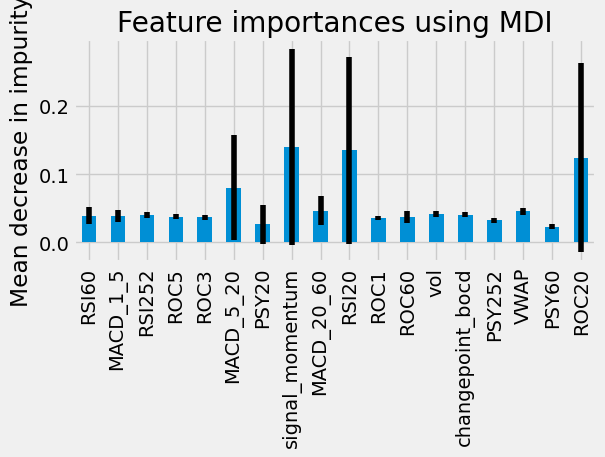

In [36]:
importances = test_model['classifier'].feature_importances_

# feature_names = trainX.drop(columns = ['Symbol']).columns

feature_names = trainX.columns


forest_importances = pd.Series(importances, index=feature_names)

std = np.std([tree.feature_importances_ for tree in test_model['classifier'].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [37]:
# import pickle

# # save the iris classification model as a pickle file
# model_pkl_file = "random_forest_model_0.8181.pkl"

# with open(model_pkl_file, 'wb') as file:
#     pickle.dump(test_model, file)

## Lasso

In [38]:
model, history = train_Lasso_supervised(trainX, trainY,1,1, num_feature= num_feature - 1,binary = True)
# model, history = train_LSTM_supervised(trainX, trainY,1,binary = True)  

Trial 100 Complete [00h 00m 36s]
loss: 0.4193105101585388

Best loss So Far: 0.4168722629547119
Total elapsed time: 00h 31m 30s
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6743
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4662
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4550
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4481
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4483
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4399
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4378
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4307
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4299
Epoch 10/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4288
Epoch 11/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4392
Epoch 12/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4249
Epoch 13/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59 (240.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40 (164.00 B)

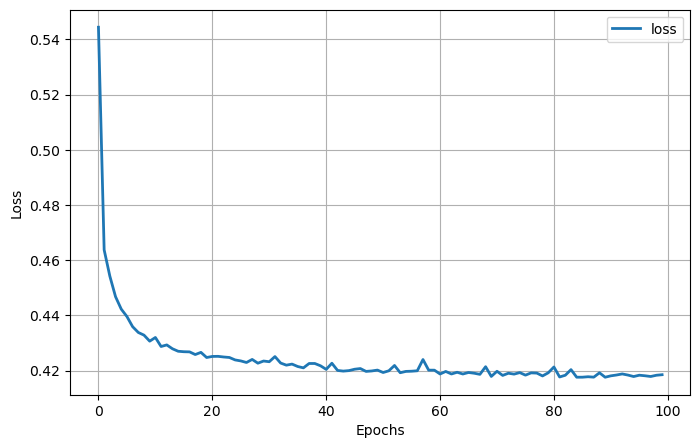

In [43]:
import seaborn as sns

pd.DataFrame(history.history).plot(figsize=(8,5), linewidth=2, grid=True)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.style.use('default')
plt.show()

In [41]:
prediction = model.predict(trainX)
print(classification_report( trainY, prediction))

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      8859
         1.0       0.75      1.00      0.86     27031

    accuracy                           0.75     35890
   macro avg       0.38      0.50      0.43     35890
weighted avg       0.57      0.75      0.65     35890



In [42]:
prediction = test_model.predict(testX)
print(classification_report( testY, prediction))

              precision    recall  f1-score   support

         0.0       0.51      0.60      0.55      2070
         1.0       0.87      0.83      0.85      6900

    accuracy                           0.78      8970
   macro avg       0.69      0.72      0.70      8970
weighted avg       0.79      0.78      0.78      8970



## MLP

In [ ]:
test_model, history = train_MLP_supervised(trainX, trainY,1,1,  num_feature= num_feature- 1,binary = True)

Trial 100 Complete [00h 00m 37s]
loss: 0.5606769323348999

Best loss So Far: 0.33298125863075256
Total elapsed time: 00h 42m 11s
Epoch 1/100
116/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0122
Epoch 1: loss improved from inf to 5.96381, saving model to Checkpoint/checkpoint_mlp_sup_binary.model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3414 
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5138
Epoch 2: loss improved from 5.96381 to 1.41007, saving model to Checkpoint/checkpoint_mlp_sup_binary.model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5131
Epoch 3/100
135/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1956
Epoch 3: loss improved from 1.41007 to 1.11446, saving model to Checkpoint/checkpoint_mlp_sup_binary.model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1917
Epoch 4/100
123/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9275
Epoch 4: loss improved from 1.11446 to 0.86309, saving model to Checkpoint/checkpoint_mlp_sup_

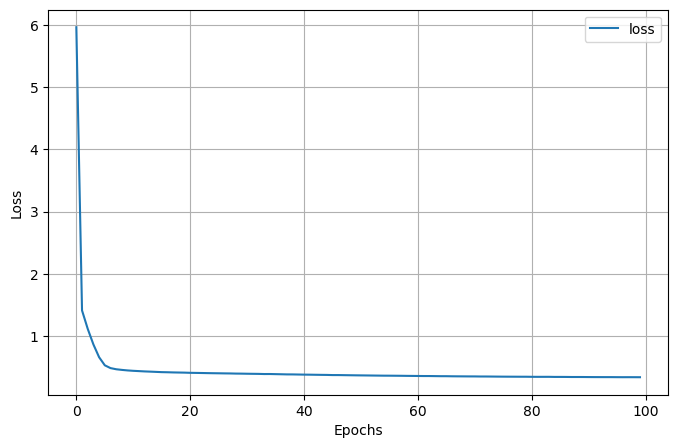

In [49]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.style.use('default')
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380 (1.49 KB)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 254 (1020.00 B)

In [51]:
prediction = model.predict(trainX)
print(classification_report(trainY, prediction))

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      8859
         1.0       0.75      1.00      0.86     27031

    accuracy                           0.75     35890
   macro avg       0.38      0.50      0.43     35890
weighted avg       0.57      0.75      0.65     35890



In [ ]:
prediction = test_model.predict(testX)
print(classification_report(testY, prediction))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      8121
         1.0       0.66      0.47      0.55       849

    accuracy                           0.93      8970
   macro avg       0.80      0.72      0.75      8970
weighted avg       0.92      0.93      0.92      8970



In [ ]:
np.unique(prediction, return_counts= True)

(array([0., 1.]), array([8361,  609], dtype=int64))

## LSTM

In [36]:
X, y,info = prepare_X_y(feature, keep = ['Symbol'])

trainX, testX ,trainY, testY, infoX,infoY = split_train_test(X, y,info)

train_df = pd.concat([trainX, trainY], axis=1)

sequence_length = 50
trainX, trainY = [], []

# Tự động lấy feature columns
feature_cols = train_df.drop(columns=["Symbol", "good_signal"]).columns

# Group theo công ty
for company_id, group in train_df.groupby("Symbol"):
    group = group.sort_index()  
    features = group[feature_cols].values
    labels = group["good_signal"].values

    for i in range(len(group) - sequence_length):
        trainX.append(features[i:i+sequence_length])
        trainY.append(labels[i+sequence_length]) 

trainX = np.array(trainX)  
trainY = np.array(trainY)  

print(trainX.shape)
print(trainY.shape)


TrainX:(35890, 18). Dữ liệu từ ngày 2019-01-04 đến 2023-12-13
TrainY:(35890,). Dữ liệu từ ngày 2019-01-04 đến 2023-12-13
TestX:(8970, 18). Dữ liệu từ ngày 2023-12-14 đến 2025-02-28
TestY:(8970,). Dữ liệu từ ngày 2023-12-14 đến 2025-02-28
(34390, 50, 17)
(34390,)


In [15]:
model, history = train_LSTM_supervised(trainX, trainY,1, num_feature= num_feature - 1,binary = True)  

Trial 2 Complete [00h 10m 27s]
loss: 0.39196696877479553

Best loss So Far: 0.3895151615142822
Total elapsed time: 00h 26m 37s
Epoch 1/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.7151
Epoch 2/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.5509
Epoch 3/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.5165
Epoch 4/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.4986
Epoch 5/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.4811
Epoch 6/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.4683
Epoch 7/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.4598
Epoch 8/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.4508
Epoch 9/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.4460
Epoch 10/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.4445
Epoch 11/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.4411
Epoch 12/100
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.4364
Epoch 13/100
538/538 ━━━━━━━━━━━━

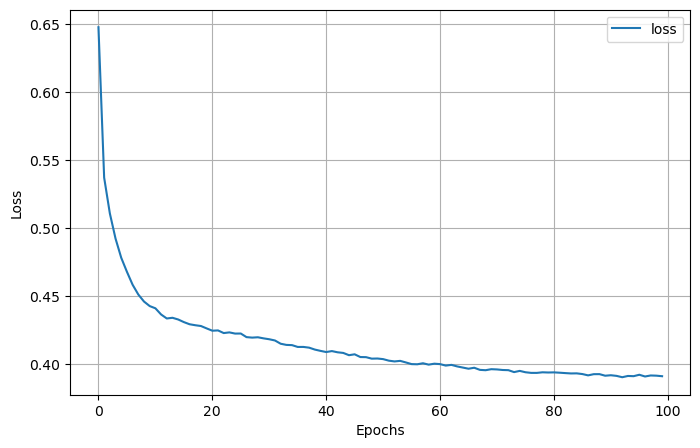

In [32]:
import seaborn as sns

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.style.use('default')
plt.show()

In [37]:
prediction = model.predict(trainX)
print(classification_report(trainY, prediction))

1075/1075 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      8588
         1.0       0.75      1.00      0.86     25802

    accuracy                           0.75     34390
   macro avg       0.38      0.50      0.43     34390
weighted avg       0.56      0.75      0.64     34390



In [ ]:
prediction = model.predict(testX)
print(classification_report( testY, prediction))